In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import rosbag
from tqdm import tqdm
import glob, os

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

width = 3.487
height = width / 1.618

%run ./scripts/util_func.py
%run ./scripts/model_func.py

def to_time(timestamp):
    return timestamp.secs + 1e-9*timestamp.nsecs



In [13]:
# import data to dataframe
# Data rate is 20 HZ

dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/husky/parsed_data/grass_1.csv')
# dataframe = dataframe.drop([0, 1, 2])

n_points = dataframe.shape[0]
n_steps = int(dataframe['calib_step'].iat[-1])
step_length = 210
steady_state_step_len = 160

print(n_steps)
print(dataframe)

215
         timestamp  imu_roll_vel  imu_pitch_vel  imu_yaw_vel  cmd_vx  \
0         0.000000      0.000000       0.000000     0.000000     0.0   
1         0.056456      0.000000       0.000000     0.000000     0.0   
2         0.106417      0.000000       0.000000     0.000000     0.0   
3         0.151805      0.000000       0.000000     0.000000     0.0   
4         0.201219     -0.000032      -0.004903    -0.000315     0.0   
...            ...           ...            ...          ...     ...   
47289  2364.451402     -0.001022       0.000108    -0.001432     0.1   
47290  2364.500847     -0.001821      -0.002145    -0.001958     0.1   
47291  2364.550206     -0.001588      -0.002174    -0.000701     0.1   
47292  2364.606586     -0.002529      -0.001212    -0.000308     0.1   
47293  2364.656759     -0.000430      -0.002226    -0.001716     0.1   

       cmd_omega      icp_x      icp_y   icp_yaw        icp_vx    icp_vy  \
0            0.0   0.000000   0.000000  0.000000  0.000

In [55]:
# compute median for each calibration step

cmd_per_step = np.zeros((n_steps, 2))
encoder_diff_drive_medians = np.zeros((n_steps, 2))
encoder_diff_drive_stddev = np.zeros((n_steps, 2))
icp_vel_medians = np.zeros((n_steps, 2))
icp_vel_stddev = np.zeros((n_steps, 2))

for i in range(0, n_points-1):
    if dataframe['calib_step'].iat[i+1] != dataframe['calib_step'].iat[i]:
        calib_step = int(dataframe['calib_step'].iat[i])
        
        cmd_per_step[calib_step, 0] = dataframe['cmd_vx'].iat[i]
        cmd_per_step[calib_step, 1] = dataframe['cmd_omega'].iat[i]
        
        encoder_diff_drive_medians[calib_step, 0] = np.median(dataframe['diff_drive_vels_x'].iloc[i-steady_state_step_len:i])
        encoder_diff_drive_medians[calib_step, 1] = np.median(dataframe['diff_drive_vels_omega'].iloc[i-steady_state_step_len:i])
        encoder_diff_drive_stddev[calib_step, 0] = np.std(dataframe['diff_drive_vels_x'].iloc[i-steady_state_step_len:i])
        encoder_diff_drive_stddev[calib_step, 1] = np.std(dataframe['diff_drive_vels_omega'].iloc[i-steady_state_step_len:i])
        icp_vel_medians[calib_step, 0] = np.median(dataframe['icp_vx'].iloc[i-steady_state_step_len:i])
        icp_vel_medians[calib_step, 1] = np.median(dataframe['imu_yaw_vel'].iloc[i-steady_state_step_len:i])
        icp_vel_stddev[calib_step, 0] = np.std(dataframe['icp_vx'].iloc[i-steady_state_step_len:i])
        icp_vel_stddev[calib_step, 1] = np.std(dataframe['imu_yaw_vel'].iloc[i-steady_state_step_len:i])
        
# print(encoder_diff_drive_stddev)

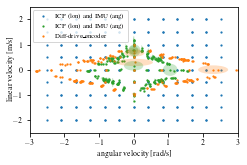

In [56]:
def create_ellipse(mean_x, mean_y, std_x, std_y):
    ellipse = Ellipse(xy = np.array([mean_x, mean_y]), 
                     width = std_x, 
                     height = std_y,
                     alpha = 0.25)
    return ellipse

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()


alpha_plot = 0.01

cmd = ax.scatter(cmd_per_step[:, 1], cmd_per_step[:, 0], 
                  c = 'tab:blue', 
                  cmap = 'hot', 
#                   alpha = alpha_plot, 
                  lw=0, 
                  s=5,
                  label='ICP (lon) and IMU (ang)',
                 rasterized=True)

icp = ax.scatter(icp_vel_medians[:,1], icp_vel_medians[:,0], 
                  c = 'tab:green', 
                  cmap = 'hot', 
#                   alpha = alpha_plot, 
                  lw=0, 
                  s=5,
                  label='ICP (lon) and IMU (ang)',
                 rasterized=True)

encoder = ax.scatter(encoder_diff_drive_medians[:, 1], encoder_diff_drive_medians[:, 0], 
                  c = 'tab:orange', 
                  cmap = 'hot', 
#                   alpha = alpha_plot, 
                  lw=0, 
                  s=5,
                  label='Diff-drive_encoder',
                 rasterized=True)

# plot confidence ellipses
for i in range(0, n_steps-1):
    ellipse_encoder = create_ellipse(encoder_diff_drive_medians[i, 1], encoder_diff_drive_medians[i, 0], 
                                    encoder_diff_drive_stddev[i, 1], encoder_diff_drive_stddev[i, 0])
    ax.add_artist(ellipse_encoder)
    ellipse_encoder.set_facecolor('tab:orange')
    ellipse_icp = create_ellipse(icp_vel_medians[i, 1], icp_vel_medians[i, 0], 
                                    icp_vel_stddev[i, 1], icp_vel_stddev[i, 0])
    ax.add_artist(ellipse_icp)
    ellipse_icp.set_facecolor('tab:green')
#     test_ellipse = create_ellipse(0,0,1,1)
#     ax.add_artist(test_ellipse)
# #     ellipse_encoder.set_alpha(0.1)


ax.set_ylabel('linear velocity [m/s]', labelpad=-2)
ax.set_xlabel('angular velocity [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(-3, 3)
ax.set_ylim(-2.5, 2.5)

# ax.set_xticks([-1,0,1])
# ax.set_yticks([-1,0,1])
# ax.set_xticklabels([r'$-\dot{\theta}_{max}$', '0', r'$\dot{\theta}_{max}$'])
# ax.set_yticklabels([r'$-v_{max}$', '0', r'$v_{max}$'])

fig.subplots_adjust(left=.15, bottom=.17, right=.98, top=.98)
fig.set_size_inches(width, height)

plt.savefig('/home/dominic/repos/norlab_WMRD/DB/figs/husky_velocities_w_icp_stats.jpg', dpi=500)